# Get $T_\mathrm{sys}$ from Autocorrelation Visibilities and Compute Noise Model 
Generate a frequency and time dependet model of the noise using calibrated autocorrelation visibilities.

In [1]:
import h5py
import glob
import numpy as np
from scipy.signal import get_window
from scipy.interpolate import interp1d

from pyuvdata import UVData
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# redundant averagig
from hera_cal.utils import red_average

## Read, Average and Select Calibrated Autocorrelation Visibilities
We are using the systematics subtracted, LST-binned H1C IDR3.2 data. Only keep "XX" and "YY" polarisation products of the redundantly averaged autocorrelation visibilities.

In [2]:
path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/zen.grp1.of1.LST.*.sum.LPXL.uvh5"

paths = glob.glob(path)
uvd_combined = UVData()
uvd_combined.read(paths[0])

# select auto-correlation pairs
auto_pairs = []
for antpair in uvd_combined.get_antpairs():
    if antpair[0] == antpair[1]:
        auto_pairs.append(antpair)

antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


In [3]:
uvd_combined.select(bls=auto_pairs, freq_chans=np.arange(535, 696), polarizations=["XX", "YY"])

# select auto baselines, frequency channels and polarisations and combine different files along LST-axis
for i, path in enumerate(paths[1:]):
    uvd = UVData()
    uvd.read(path)
    uvd.select(bls=auto_pairs, freq_chans=np.arange(535, 696), polarizations=["XX", "YY"])
    uvd_combined += uvd

lst = uvd_combined.lst_array * 12 / np.pi
lst = np.unique(lst)

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
antenna_diameters is not set. Using known values for HERA.
Fixing auto-correlations to be be 

In [4]:
lst_array = uvd_combined.lst_array * 12 / np.pi
lst_array_unique = np.unique(lst_array)

flags = uvd_combined.flag_array
autos = uvd_combined.data_array.copy()
autos[flags] = np.nan

autos = np.array([autos[np.where(lst_array == lst)] for lst in lst_array_unique])[:, :, 0]
print(autos.shape)

(4010, 48, 161, 2)


In [5]:
autos = np.moveaxis(autos, (1, 3), (0, 1))
autos_avg = np.sqrt(np.nanmean(autos**2, axis=(0, 1)))
autos_dev = np.nanstd(autos - autos_avg, axis=(0, 1))

Mean of empty slice
Degrees of freedom <= 0 for slice.


In [6]:
print(f"Mean standard deviation of T_sys: {np.nanmean(autos_dev / autos_avg)}")

Mean standard deviation of T_sys: (0.16767260092994693+0j)


invalid value encountered in true_divide


## Compute System Temperature
Using the averaged autocorrelations $V_\mathrm{auto}(t, \nu)$, we estimate the system temperature as $T_\mathrm{sys}(t, \nu) = \frac{c^2 V_\mathrm{auto}(t, \nu)}{2k_\mathrm{b}\nu^2\Omega}$, where $\Omega$ is the integrated beam response. 

In [7]:
def Tsys_from_autos(auto1, auto2, freq, omega):
    """
    compute Tsys from auto corralation visibilities
    """   
    return c**2 * np.sqrt(auto1 * auto2) / (2 * kb * freq**2 * omega) * 1e-26

In [8]:
# read Omega
omega_path = "/lustre/aoc/projects/hera/pkeller/HERA-Beams/NicolasFagnoniBeams/Omega_Dipole.dat"
omega = np.loadtxt(omega_path)[535:696]

# frequencies
freq = uvd_combined.freq_array[0]

# constants
c =  299792458
kb = 1.3806503 * 1e-23

# compute Tsys
nsig = 2
Tsys = Tsys_from_autos(autos_avg, autos_avg, freq, omega)

## Plot System Temperature

Casting complex values to real discards the imaginary part


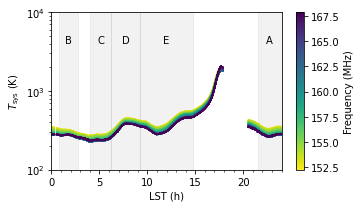

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))

colors = np.linspace(0, 1, Tsys.shape[-1])

dummie_cax = ax.scatter(freq*1e-6, freq*1e-6, c=freq*1e-6, cmap="viridis_r")
ax.clear()

for i in range(len(colors)):
    cbar = ax.plot(lst_array_unique, Tsys[:, i], color=cm.viridis_r(i/len(colors)));

fields = [[21.5, 24], [0.75, 2.75], [4.0, 6.25], [6.25, 9.25],[9.25, 14.75]]
fieldnames = ["A", "B", "C", "D", "E"]

for (t1, t2), fname in zip(fields, fieldnames):
    ax.axvspan(t1, t2, alpha=0.05, color='k')
    ax.text(0.5 * (t1 + t2), 4*1e3, fname, ha="center")

ax.minorticks_on()
fig.colorbar(dummie_cax, label="Frequency (MHz)")

plt.xlim([0, 24])
plt.ylim(bottom=1e2, top=1e4)
plt.xlabel("LST (h)")
plt.ylabel(r"$T_\mathrm{sys}$ (K)")
plt.yscale("log")
plt.tight_layout()
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/Tsys.png", dpi=600)

Mean of empty slice


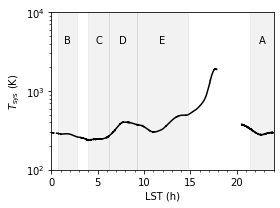

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

colors = np.linspace(0, 1, Tsys.shape[-1])

dummie_cax = ax.scatter(freq*1e-6, freq*1e-6, c=freq*1e-6, cmap="gist_heat_r")
ax.clear()

ax.plot(lst, np.nanmean(Tsys, axis=-1), color="k", linestyle="solid");
#ax.plot(lst, np.nanmean(Tsys_lo, axis=-1), color="k", linestyle="solid", linewidth=0.5);
#ax.plot(lst, np.nanmean(Tsys_hi, axis=-1), color="k", linestyle="solid", linewidth=0.5);

for (t1, t2), fname in zip(fields, fieldnames):
    ax.axvspan(t1, t2, alpha=0.05, color='k')
    ax.text(0.5 * (t1 + t2), 4*1e3, fname, ha="center")

ax.minorticks_on()

plt.xlim([0, 24])
plt.ylim(bottom=1e2, top=1e4)
plt.xlabel("LST (h)")
plt.ylabel(r"$T_\mathrm{sys}$ (K)")
plt.yscale("log")
plt.tight_layout()
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/Tsys.pdf")

## Compute and Plot Noise RMS
We can now compute the noise using the radiometer equation $\sigma = \frac{\sqrt{2} \Omega \nu^2 k_bT_\mathrm{sys}}{c^2 \sqrt{\Delta t \Delta \nu}}$.

In [11]:
std = np.sqrt(2) * freq**2 * omega * kb * Tsys / (c**2 * np.sqrt(10.7 * 100 / 1024 * 1e6)) * 1e26

Casting complex values to real discards the imaginary part


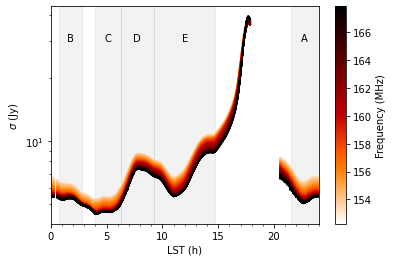

In [12]:
fig, ax = plt.subplots()

colors = np.linspace(0, 1, Tsys.shape[-1])

dummie_cax = ax.scatter(freq*1e-6, freq*1e-6, c=freq*1e-6, cmap="gist_heat_r")
ax.clear()

for i in range(len(colors)):
    cbar = ax.plot(lst, std[:, i], color=cm.gist_heat_r(i/len(colors)));

for (t1, t2), fname in zip(fields, fieldnames):
    ax.axvspan(t1, t2, alpha=0.05, color='k')
    ax.text(0.5 * (t1 + t2), 3e1, fname, ha="center")

ax.minorticks_on()
fig.colorbar(dummie_cax, label="Frequency (MHz)")

plt.xlim([0, 24])
plt.xlabel("LST (h)")
plt.ylabel(r"$\sigma$ (Jy)")
plt.yscale("log")

## Write to File
Write the noise RMS as a function of time and frequency to a file.

In [13]:
path = "/users/pkeller/code/H1C_IDR3.2/data/noise_std.h5"

f = h5py.File(path, "w")
f.create_dataset(f"Tsys", data=Tsys)
f.create_dataset(f"RMS", data=std)
f.create_dataset(f"LST", data=lst)

f.close()